# 4. ionbot

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
folder = "http://genesis.ugent.be/uvpublicdata/workshop-ml-proteomics/4-Ionbot/"
dataset = "PXD001250"

#conditions: "_nort","_nocorr","_nocorr_nort","_closed"
condition = "_nocorr_nort"

In [9]:
def get_ionbot_condition(condition,folder,dataset):
    #read consition results
    ionbot_c = pd.read_csv("%s/%s%s/ionbot.first.csv"%(folder,dataset,condition))
    ionbot_c["rank"] = ["first"]*len(ionbot_c)

    tmp = pd.read_csv("%s/%s%s/ionbot.lower.csv"%(folder,dataset,condition))
    tmp["rank"] = ["lower"]*len(tmp)
    ionbot_c = pd.concat([ionbot_c,tmp])

    tmp = pd.read_csv("%s/%s%s/ionbot.features.csv"%(folder,dataset,condition))
    ionbot_c = ionbot_c.merge(tmp,on="ionbot_match_id",how="left")

    ionbot_c["PSM"] = ionbot_c["scan"].astype(str) + ionbot_c["spectrum_file"] +  "|PSM|" +  ionbot_c["matched_peptide"]
    ionbot_c["num_matches"] = ionbot_c.groupby(["spectrum_file","scan"])["scan"].transform("count")
    return ionbot_c


In [10]:
ionbot = get_ionbot_condition("",folder,dataset)
ionbot_c = get_ionbot_condition("_nocorr_nort",folder,dataset)

In [25]:
len(ionbot.index)
len(ionbot_c.index)

len(set(ionbot["matched_peptide"]+"|"+ionbot["modifications"].fillna("")))
len(set(ionbot["matched_peptide"]+"|"+ionbot["modifications"].fillna("")))

len(set(ionbot["proteins"]))

85893

In [17]:
list(ionbot.columns)

['ionbot_match_id',
 'spectrum_title',
 'scan',
 'spectrum_file',
 'precursor_mass',
 'peptide_mass',
 'observed_retention_time',
 'charge',
 'database_peptide',
 'matched_peptide',
 'modifications',
 'modifications_delta',
 'best_tag_rank',
 'corrected_retention_time',
 'unexpected_modification',
 'database',
 'psm_score',
 'q-value',
 'PEP',
 'proteins',
 'sfile',
 'PSM',
 'rank',
 'by-count',
 'all-count',
 'by-explained',
 'all-explained',
 'by-intensity-pattern-correlation',
 'predicted_retention_time',
 'rt-pred-error',
 'num_matches']

In [4]:
s1 = set(ionbot["PSM"])
s2 = set(ionbot_c["PSM"])

#matches unique to ionbot
s = s1.difference(s2)
ionbot["unique"] = ionbot["PSM"].apply(lambda x: x in s)
print(ionbot["unique"].value_counts())

#matches unique to ionbot_c
s = s2.difference(s1)
ionbot_c["unique"] = ionbot_c["PSM"].apply(lambda x: x in s)
print(ionbot_c["unique"].value_counts())

False    372860
True      67105
Name: unique, dtype: int64
False    372860
True      10586
Name: unique, dtype: int64


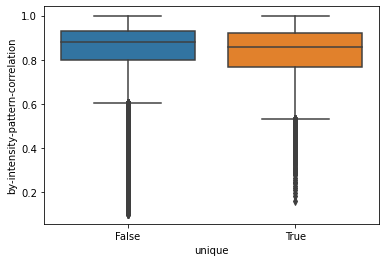

In [5]:
sns.boxplot(x="unique",y="by-intensity-pattern-correlation",data=ionbot)

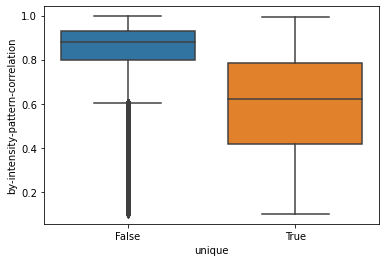

In [6]:
sns.boxplot(x="unique",y="by-intensity-pattern-correlation",data=ionbot_c)

In [7]:
def get_universal_link(x):
    if str(x["modifications"]) == "nan":
        return "http://proteomecentral.proteomexchange.org/usi/?usi=mzspec:%s:%s:scan:%i:%s/%i"%(dataset,x["spectrum_file"],x["scan"],x["matched_peptide"],x["charge"])
    tmp = x["modifications"].split("|")
    seq = list(x["matched_peptide"])
    for i in range(0,len(tmp),2):
        if tmp[i] == "x": #not observed in MS1
            continue
        if tmp[i+1][0] != "[": #mutation
            continue
        mod = int(tmp[i+1].split(']')[0][1:])
        if mod == 4:
            continue
        pos = int(tmp[i])
        seq.insert(pos,"[UNIMOD:%i]"%mod)
    return "http://proteomecentral.proteomexchange.org/usi/?usi=mzspec:%s:%s:scan:%i:%s/%i"%(dataset,x["spectrum_file"],x["scan"],''.join(seq),x["charge"])

ionbot["USI"] = ionbot.apply(get_universal_link,axis=1)